# Importing Libraries

In [41]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import io

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


# Download Dataset

In [2]:
URL = 'https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P'

In [3]:
file_path = tf.keras.utils.get_file('sentiments.csv', URL)
print(file_path)

139264/127831 [================================] - 0s 0us/step
/root/.keras/datasets/sentiments.csv


In [4]:
dataset = pd.read_csv(file_path)
dataset.head()

,Unnamed: 0,text,sentiment
0,0,So there is no way for me to plug it in here i...,0
1,1,Good case Excellent value.,1
2,2,Great for the jawbone.,1
3,3,Tied to charger for conversations lasting more...,0
4,4,The mic is great.,1


In [5]:
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

len(sentences), len(labels)

(1992, 1992)

In [13]:
type(sentences)

list

# Creating subword Dataset

In [6]:
VOCAB_SIZE = 1000

In [7]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(corpus_generator=sentences,
                                                                      target_vocab_size=VOCAB_SIZE,
                                                                      max_subword_length=5)
tokenizer

<SubwordTextEncoder vocab_size=999>

In [12]:
# Check the tokenizer
num = 5
print(sentences[num])

encoded = tokenizer.encode(sentences[num])
print(encoded)

for i in encoded:
  print(i, ' --> ', tokenizer.decode([i]))

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
4  -->  I 
31  -->  have 
6  -->  to 
849  -->  j
162  -->  ig
450  -->  gl
12  -->  e 
1  -->  the 
600  -->  pl
438  -->  ug
775  -->   
6  -->  to 
175  -->  get 
14  -->  it 
6  -->  to 
55  -->  li
213  -->  ne 
159  -->  up 
474  -->  right
775  -->   
6  -->  to 
175  -->  get 
614  -->  dec
380  -->  ent 
295  -->  vo
148  -->  lu
72  -->  me
789  -->  .


In [16]:
for i,sentence in enumerate(sentences):
    sentences[i] = tokenizer.encode(sentence)

In [17]:
print(sentences[0])

[736, 168, 775, 7, 193, 417, 17, 94, 6, 600, 438, 775, 14, 19, 141, 19, 1, 828, 826, 775, 99, 445, 4, 174, 361, 5, 79, 227, 139, 789]


# Splitting Dataset

In [18]:
MAX_LENGTH = 50
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'

In [19]:
padded_sentences = pad_sequences(sequences=sentences,
                                 maxlen=MAX_LENGTH,
                                 padding=PADDING_TYPE,
                                 truncating=TRUNC_TYPE)
padded_sentences[0]

array([736, 168, 775,   7, 193, 417,  17,  94,   6, 600, 438, 775,  14,
        19, 141,  19,   1, 828, 826, 775,  99, 445,   4, 174, 361,   5,
        79, 227, 139, 789,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [20]:
training_size = int(len(sentences) * 0.8)
training_size

1593

In [29]:
training_sentences = padded_sentences[:training_size]
testing_sentences = padded_sentences[training_size:]

training_labels = labels[:training_size]
testing_labels = labels[training_size:]

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

len(training_sentences), len(training_labels), len(testing_sentences), len(testing_labels)

(1593, 1593, 399, 399)

In [30]:
type(testing_labels_final)

numpy.ndarray

# Train a Model

In [31]:
EMBEDDING_DIM = 16

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE,
                              EMBEDDING_DIM,
                              input_length=MAX_LENGTH),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [33]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [35]:
NUM_EPOCHS = 30

history = model.fit(x=training_sentences,
                    y=training_labels_final,
                    epochs=NUM_EPOCHS,
                    validation_data=(testing_sentences, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 1s 5ms/step - loss: 0.6915 - accuracy: 0.5298 - val_loss: 0.6969 - val_accuracy: 0.4261
Epoch 2/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6875 - accuracy: 0.5455 - val_loss: 0.6976 - val_accuracy: 0.4511
Epoch 3/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.5895 - val_loss: 0.6909 - val_accuracy: 0.4912
Epoch 4/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6662 - accuracy: 0.6171 - val_loss: 0.6742 - val_accuracy: 0.6065
Epoch 5/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6470 - accuracy: 0.6886 - val_loss: 0.6666 - val_accuracy: 0.5489
Epoch 6/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6193 - accuracy: 0.7332 - val_loss: 0.6381 - val_accuracy: 0.6892
Epoch 7/30
50/50 [==============================] - 0s 2ms/step - loss: 0.5834 - accuracy: 0.7979 - val_loss: 0.6214 - val_accuracy: 0.6742
Epoch 8/30
50/50 [==

In [36]:
model_loss_acc = model.evaluate(testing_sentences, testing_labels_final)
model_loss_acc

13/13 [==============================] - 0s 1ms/step - loss: 0.5828 - accuracy: 0.7519


[0.5827925801277161, 0.7518796920776367]

# Visualize Loss & Accuracy Graph

In [37]:
def plot_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

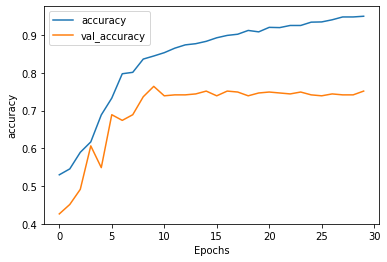

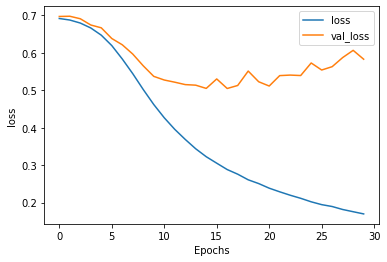

In [38]:
plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

In [39]:
# Get the weights of the embedding layer
layer0 = model.layers[0]
print(layer0)

layer0_weights = layer0.get_weights()[0]
print(len(layer0_weights), layer0_weights.shape)

print(layer0_weights[0])


1000 (1000, 16)
[ 0.10100801  0.05970245  0.03043834 -0.14450477 -0.01765925 -0.05822667
 -0.10485138  0.04902029 -0.14446731 -0.09406416  0.02157541  0.03176768
  0.08299045  0.08558612 -0.03947109 -0.02464831]


In [43]:
# Write Embedding Vectors and Metadata

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(0, VOCAB_SIZE-1):
  word = tokenizer.decode([word_num])
  embeddings = layer0_weights[word_num]
  out_m.write(word + '\n')
  out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')

out_v.close()
out_m.close()

In [44]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>